In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


!pip install scikit-learn-extra
!pip install gower

import gower

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 9.3 MB/s eta 0:00:00m eta 0:00:01


In [2]:
# Reading the raw data
cost_discharge_df = pd.read_excel("../data/raw/cost_discharge_physpec_ippct.xlsx")

In [3]:
cost_discharge_df.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127


In [ ]:
cost_discharge_df.corr()

,pat_cost,discharge_to_home_pct,IP_pct
pat_cost,1.000000,-0.578340,0.669526
discharge_to_home_pct,-0.578340,1.000000,-0.791021
IP_pct,0.669526,-0.791021,1.000000


In [ ]:
# Fix group col with break characters
cost_discharge_df.group = cost_discharge_df.group.apply(lambda x: x.replace(u'\xa0', u' '))

In [ ]:
print(f"Possible Phy Spec categories: {len(set(cost_discharge_df['phy_spec']))}")
print(f"Unique groups: {len(set(cost_discharge_df['group']))}")

Possible Phy Spec categories: 13
Unique groups: 49


In [ ]:
# Compute gower dist matrix for all numerical, cat and ord cols
dist_matrix = gower.gower_matrix(cost_discharge_df)

In [ ]:
dist_matrix.shape

(50, 50)

### Using *DBScan*

In [ ]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.4, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(dist_matrix)

DBSCAN(eps=0.4, metric='precomputed', min_samples=2)

In [ ]:
cost_discharge_df['discharge_category_dbscan'] = dbscan_cluster.labels_

In [ ]:
dbscan_cluster.labels_

array([ 0, -1,  0,  1, -1,  2, -1,  3,  3,  3, -1,  3,  0,  1,  0,  2,  1,
        1, -1, -1,  4,  5,  3,  1,  1,  4,  4,  1,  0,  0,  0,  0,  2,  6,
        6,  5,  0,  0,  0,  0,  0,  1,  0,  2,  3,  0, -1,  0,  4,  0])

In [ ]:
dbscan_cluster.metric_params

In [ ]:
cost_discharge_df[cost_discharge_df.discharge_category_dbscan == 3]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan
7,cardiac ablation,22307.6292,0.926094,CARDIOVASCULAR DISEASES (CD),0.279960,3
8,cardiac ablation_additional_discrete,23310.1182,0.992888,CARDIOVASCULAR DISEASES (CD),0.000000,3
9,cardiac ablation_linear_focal,23227.2749,0.994481,CARDIOVASCULAR DISEASES (CD),0.000000,3
11,cardiac_ablaton_ice,21564.2802,0.992072,CARDIOVASCULAR DISEASES (CD),0.000000,3
22,laac,26641.5200,0.919479,CARDIOVASCULAR DISEASES (CD),0.972062,3
44,tavr,29582.2368,0.877698,CARDIOVASCULAR DISEASES (CD),0.000000,3


In [ ]:
cost_discharge_df[cost_discharge_df.discharge_category_dbscan == 4]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan
20,intracranial_thromb,41302.4483,0.247098,INTERNAL MEDICINE (IM),0.996995,4
25,lung ablation,18846.2792,0.766509,HOSPITALIST (HOS),0.536557,4
26,lung ablation,18846.2792,0.766509,INTERNAL MEDICINE (IM),0.536557,4
48,tpa,28537.1330,0.472749,INTERNAL MEDICINE (IM),1.000000,4


In [ ]:
cost_discharge_df[cost_discharge_df.discharge_category_dbscan == -1]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495,-1
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127,-1
6,bunionectomy,6344.0255,0.977562,PODIATRY (POD),0.000000,-1
10,cardiac_ablaton_anesthesia,17757.4340,0.992291,CARDIAC ELECTROPHYSIOLOGY (ICE),0.000000,-1
18,hip_fracture_fixation,20244.9977,0.085826,HOSPITALIST (HOS),0.992639,-1
19,hysterect,10254.5665,0.966278,OBSTETRICS/GYNECOLOGY (OBG),0.360516,-1
46,thoracic,26456.1815,0.685308,THORACIC SURGERY (TS),0.917489,-1


### Using *KMedoids*

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
num_clusters = 4

num_clusters = [i for i in range(2,8)]
inertias = []
for n_cluster in num_clusters:
  kmedoids = (KMedoids(n_clusters=n_cluster, 
                            metric='precomputed',
                            method='pam', init='build', 
                            max_iter=300, 
                            random_state=42)
              .fit(dist_matrix))
  inertias.append(kmedoids.inertia_)


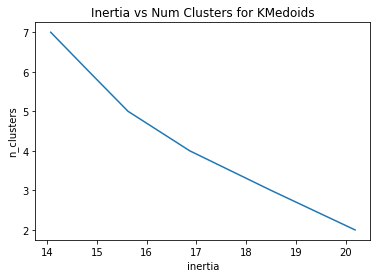

In [ ]:
# Compare the intertis wrt diff num of clusters

plt.plot(inertias,num_clusters)
plt.xlabel('inertia')
plt.ylabel('n_clusters')
plt.title('Inertia vs Num Clusters for KMedoids')
plt.show()

As per the plot, 5 seems to be the optimal value.

In [ ]:
kmedoids = (KMedoids(n_clusters=5, 
                            metric='precomputed',
                            method='pam', init='build', 
                            max_iter=300, 
                            random_state=42)
              .fit(dist_matrix))

In [ ]:
cost_discharge_df["discharge_category_kmedoids"] = kmedoids.labels_

In [ ]:
kmedoids.labels_

array([0, 3, 2, 3, 0, 4, 4, 1, 1, 1, 1, 1, 0, 3, 2, 4, 3, 3, 2, 0, 2, 0,
       1, 3, 3, 3, 3, 3, 0, 0, 0, 0, 4, 2, 2, 3, 2, 0, 0, 2, 2, 3, 0, 4,
       1, 2, 2, 2, 2, 2])

In [ ]:
cost_discharge_df[cost_discharge_df["discharge_category_kmedoids"] == 4]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan,discharge_category_kmedoids
5,bsp,7324.2300,0.983472,OTOLARYNGOLOGY (OTO),0.0,2,4
6,bunionectomy,6344.0255,0.977562,PODIATRY (POD),0.0,-1,4
15,fess,5896.7557,0.982442,OTOLARYNGOLOGY (OTO),0.0,2,4
32,pnn,4324.9976,0.983992,OTOLARYNGOLOGY (OTO),0.0,2,4
43,septoplasty,5136.1079,0.980543,OTOLARYNGOLOGY (OTO),0.0,2,4


In [ ]:
cost_discharge_df[cost_discharge_df["discharge_category_kmedoids"] == 1]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,discharge_category_dbscan,discharge_category_kmedoids
7,cardiac ablation,22307.6292,0.926094,CARDIOVASCULAR DISEASES (CD),0.279960,3,1
8,cardiac ablation_additional_discrete,23310.1182,0.992888,CARDIOVASCULAR DISEASES (CD),0.000000,3,1
9,cardiac ablation_linear_focal,23227.2749,0.994481,CARDIOVASCULAR DISEASES (CD),0.000000,3,1
10,cardiac_ablaton_anesthesia,17757.4340,0.992291,CARDIAC ELECTROPHYSIOLOGY (ICE),0.000000,-1,1
11,cardiac_ablaton_ice,21564.2802,0.992072,CARDIOVASCULAR DISEASES (CD),0.000000,3,1
22,laac,26641.5200,0.919479,CARDIOVASCULAR DISEASES (CD),0.972062,3,1
44,tavr,29582.2368,0.877698,CARDIOVASCULAR DISEASES (CD),0.000000,3,1


In [ ]:
kmedoids.inertia_

15.6278

In [ ]:
# Writing the data in preprocessed folder
cost_discharge_df.to_csv('../data/preprocessed/discharge_physpec_categorised.csv', index=False)